# Introduction of Bayesian model estimation
The aim of the introduction is to simply demonstrate how to use Bayesian model estimation to estimate the parameters of a model.

The example we use in this introduction is to find the relationship between the level of assistance and the level of self-efficacy for experimental participants. More precisely, we want to know how level of assistance affects the level of self-efficacy. We will use the Bayesian model estimation to estimate relationship. 

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import os

def plot_model(x, y):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(x, y)
    ax.set_xlabel("Assistance")
    ax.set_ylabel("Normalised self-efficacy")
    ax.set_title("Assistance vs Normalised self-efficacy")
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True)
    plt.show()

# Participant 
In this example, we simply assume that the relationship between the level of assistance and the level of self-efficacy follows a specific function which maps the level of assistance to the level of self-efficacy. Therefore, this function is our **model** of the relationship. 

For example, if we assume the relationship is linear, then the model is:

$$
\begin{align}
\text{self-efficacy} = \text{intercept} + \text{slope} \times \text{assistance}
\end{align}
$$

with two parameters: intercept and slope.

Assuming the slope = 0.9 and intercept = 0.2, the relationship between the level of assistance and the level of self-efficacy is shown in the following figure.

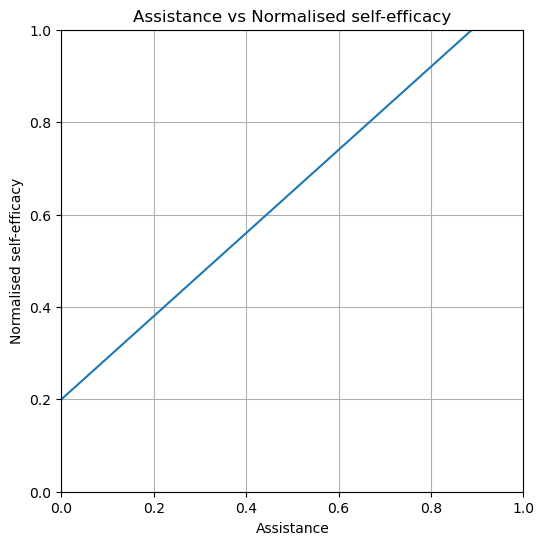

In [9]:
def f_linear(x, slope, intercept):
    return slope * x + intercept

# Plot model
slope = 0.9
intercept = 0.2
x = np.linspace(0, 1, 100)
y = f_linear(x, slope, intercept)
plot_model(x, y)

## A slightly more complicated model
In the above example, we assume the relationship between the level of assistance and the level of self-efficacy is linear. However, in reality, the relationship is more complicated. For example, the relationship may be quadratic, cubic, or even more complicated. 

A more realistic scenario would be the relationship is an _inverse U shape_. In this case, the model we can use a function which can flexibly fit the inverse U shape relationship. For example, we can use a modified version of the function of beta distribution to model the relationship.

In [ ]:
def f_BetaNorm(alpha, beta, x):
    # without scipy.stats.beta
    x_max = (alpha - 1) / (alpha + beta - 2)
    y = x**(alpha-1) * (1 - x)**(beta-1)
    y_max = x_max**(alpha-1) * (1 - x_max)**(beta-1)
    y_normalized = y / y_max
    return y_normalized

It's mathematical form is:

$$
\begin{align}
\text{self-efficacy} = \text{intercept} + \text{scale} \times \text{beta}(\text{shape1}, \text{shape2})
\end{align}
$$
